In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import qcodes
qc = qcodes

In [54]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

In [4]:
from labtools.mplplots import init_nb_plotting
reload(init_nb_plotting)
from labtools.mplplots.init_nb_plotting import *

from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

In [ ]:
# from quantum_capacitance import rf; reload(rf)
# from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [8]:
%run init.py

2018-02-23 12:34:07,305 : measurement : INFO : Logger set up!
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Instrument ivvi already exists.
Instrument sr1 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.20s

C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:616: UserWarning: set_validator is deprected use `inst.vals = MyValidator` instead
  "set_validator is deprected use `inst.vals = MyValidator` instead")


In [6]:
station.ivvi.set_dacs_zero()

In [7]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

In [ ]:
# from stationq.qctools.instruments import create_inst
# from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
# from visa import VisaIOError

# def check_keys(ivvi):
#     key1 = create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR", force_new_instance=True)
#     key2 = create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR", force_new_instance=True)
#     station = qc.Station(ivvi, key1, key2)
#     return station

# station = check_keys(station.ivvi)

# Definitions

# Experiments

In [100]:
station.ivvi.set_dacs_zero()

In [ ]:
station.ivvi.dac1(1000)

In [9]:
station.key2.volt()

-0.00299171685

In [25]:
station.sr1.time_constant(100e-3)

In [ ]:
station.sr1.amplitude(1e-6)

In [ ]:
station.sr1.X()

In [ ]:
station.sr1.X_offset()

In [ ]:
station.sr1.sensitivity(100e-3)

In [ ]:
station.sr1.input_shield('float')

In [ ]:
station.sr1.sine_outdc(0)

## DC IV traces

In [91]:
from stationq.experiment.measurement import BaseMeasurement

class IVCurve(BaseMeasurement):
    
    start = -150e-6
    stop = +150e-6
    pts = 151
    nplc = 10
    delay = 0.01
    sine_amp = 0.1

    def measure(self):        
        vals = []
        bias = np.linspace(self.start, self.stop, self.pts) * 1e6
        
        self.station.sr1.amplitude(self.sine_amp)
        self.station.ivvi.dac1(bias[0])
        time.sleep(1)
        
        for v in bias:
            self.station.ivvi.dac1(v)
            time.sleep(self.delay)

            li_X = self.station.sr1.X()
            li_Y = self.station.sr1.Y()
            key_volt = self.station.key2.volt()
            
            self.data.add(
            OrderedDict({
                'Bias' : {'value' : v * 1e-6, "unit": 'V', "independent_parameter": True},
                'Lockin X' : {'value' : li_X, "unit" : 'V'},
                'Lockin Y' : {'value' : li_Y, "unit" : 'V'},
                'DMM voltage' : {'value' : key_volt, 'unit' : 'V'},
                })
            )
            

In [101]:
m = IVCurve(station, namespace, info_string=f'testing')
m.start = -300e-6
m.stop = 300e-6
m.pts = 101
m.delay = 0.1
m.run()

2018-02-23 15:45:03,374 : measurement : INFO : Ready to measure, file location: d:\data\2018-02\2018-02-23\2018-02-23_IVCurve-#0016_testing...
2018-02-23 15:46:05,735 : measurement : INFO : Measurement finished, cleaning up...
2018-02-23 15:46:05,834 : measurement : INFO : All done!


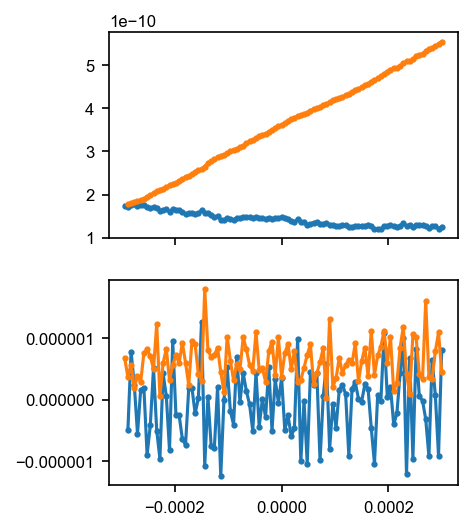

In [102]:
bias = m.data['Lockin X']['Bias [V]'].reshape(-1).copy()[1:]
X_sr = m.data['Lockin X']['Lockin X [V]'].reshape(-1).copy()[1:]
Y_sr = m.data['Lockin Y']['Lockin Y [V]'].reshape(-1).copy()[1:]
V_dmm = m.data['DMM voltage']['DMM voltage [V]'].reshape(-1).copy()[1:]


I_dmm = V_dmm * 1e-7
dIdV_dmm = np.diff(I_dmm)/np.diff(bias)

dV_sr = (X_sr**2 + Y_sr**2)**.5
dI_sr = dV_sr * 1e-7
dIdV_sr = dI_sr/(0.1 * 1e-5)
I_sr = cumtrapz(dIdV_sr, bias)


fig, (ax, bx) = plt.subplots(2, 1, figsize=(3,4), sharex=True)
# ax.plot(bias, V_sr, 'o-', ms=2)
ax.plot(bias, I_dmm, 'o-', ms=2)
ax.plot(bias[1:], I_sr + I_dmm[0], 'o-', ms=2)

bx.plot(bias[1:], dIdV_dmm, 'o-', ms=2)
bx.plot(bias, dIdV_sr, 'o-', ms=2)

# ax.plot(bias, Int, 'o-', ms=2)
# ax.plot(bias[1:], didv)

In [103]:
(bias.max() - bias.min()) / (I_dmm.max() - I_dmm.min())

10336283.501217309

In [ ]:
# T = 100
# t0 = time.time()
# delay = 5

t0 = time.time()
idx = 0
# npts = 4001

# while True:

#     for avgs in [201, 401, 801, 1601]:
    
    ### measure IV trace
m = IVCurve(station, namespace, info_string=f'{npts}_testing')
m.start = 140
m.stop = 240
m.pts = 2001
m.nplc = 10
m.delay = 0.02
m.run()

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

i -= i[i.size//2]
bias *= 1e6
i *= 1e9

fig, ax = plt.subplots(1, 1)
ax.plot(bias, i, 'o', ms=1)
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.grid(dashes=[2,2])
fig.savefig(m.data_prefix + ".png", dpi=300)

#     time.sleep(60)

    ### measure current as function of time
#     if idx in [0,1]:
#         m = IMonitor(station, namespace)
#         m.npts = 20000
#         m.nplc = 1
#         m.delay = 0.1
#         m.bias = 190
#         m.run()

#         t = m.data['Current']['time [s]'].reshape(-1).copy()
#         i = m.data['Current']['Current [A]'].reshape(-1).copy()
#         v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

#         fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
#         ax.plot(t, i * 1e9, 'o', ms=2)
#         bx.plot(t, v * 1e6, 'o', ms=2)
#         ax.set_ylabel('I (nA)')
#         bx.set_ylabel('V (uV)')
#         bx.set_xlabel('time (s)')
#         ax.grid(dashes=[2,2])
#         bx.grid(dashes=[2,2])
#         fig.savefig(m.data_prefix + ".png", dpi=300)

#         time.sleep(2)
    
#     idx+=1
    
#     plt.close('all')

In [ ]:
t = m.data['Current']['time [s]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(time, i * 1e9, 'o', ms=2)
bx.plot(time, v * 1e6, 'o', ms=2)
ax.set_ylabel('I (nA)')
bx.set_ylabel('V (uV)')
bx.set_xlabel('time (s)')

In [ ]:
# bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
# i = m.data['Current']['Current [A]'].reshape(-1).copy()
# v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

# i -= i[i.size//2]
# v -= v[v.size//2]
# v *= 1e6
# i *= -1e9

# i_of, v_of = find_offset(i, v, smooth_win=50)
# i -= i_of
# v -= v_of

# fig, ax = plt.subplots(1, 1)
# ax.plot(bias * 1e3, i * 1e6, 'o', ms=1)

# fig, ax = plt.subplots(1,1)
# ax.plot(bias * 1e3, v * 1e3, 'o', ms=1)

In [ ]:
R = 15e3 + 12e3 + 2*1.7e3

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

i -= i[i.size//2]
# v -= v[v.size//2]
# v = bias
# v -= i*R
# v -= 10e-6
v *= -1e6
i *= 1e9

i_of, v_of = find_offset(i, v, smooth_win=50)
i -= i_of
v -= v_of

fig, ax = plt.subplots(1, 1)
ax.plot(v, i, 'o', ms=1)

# kwarg = dict( 
#     ilim=None, vlim=(162, 185),
# #     vlim=None, ilim=(0.015, 0.2),
# )
# vfit, ifit, T = fit_linslope(i, v, **kwarg)
# ax.plot(vfit, ifit, label=f'T(fit) = {T*1e3:.1f} mK')
# if kwarg['ilim'] is not None:
#     ax.axhline(kwarg['ilim'][0], dashes=[1,1], lw=1, color='k')
# if kwarg['vlim'] is not None:
#     ax.axvline(kwarg['vlim'][0], dashes=[1,1], lw=1, color='k')

# ax.set_yscale('log')
# ax.set_xlim(100, 200)

ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.legend()
fig.savefig(m.data_prefix + "_fit.png", dpi=300)

In [ ]:
station.ivvi.set_dacs_zero()

In [ ]:
station.ivvi.dac1()

In [ ]:
### Testing: for use with sample simulator.

m = IVCurve(station, namespace)
m.start = -200
m.stop = 200
m.pts = 21
m.run()

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

fig, ax = plt.subplots(1,1)
ax.plot(bias * 1e3, i * 1e6, 'o')

fig, ax = plt.subplots(1,1)
ax.plot(bias * 1e3, v * 1e3, 'o')

fig, ax = plt.subplots(1,1)
ax.plot(v * 1e3, i * 1e6, 'o')

R = 12e3
bias2 = bias - i*R
fig, ax = plt.subplots(1,1)
ax.plot(bias2 * 1e3, i * 1e6, 'o')

dv = v[-1] - v[0]
di = i[-1] - i[0]
print(dv/di)

dv = bias2[-1] - bias2[0]
di = i[-1] - i[0]
print(dv/di)

In [ ]:
100e-6 / 22e3 * 1e7